# Introduction

In this tutorial, we demonstrate how to use CINEMA-OT to reveal the perturbation effect induced by various interferon treatment on PBMC immune cells. We will focus on one sample (H3D2, acute stimulation) and reproduce analysis results in the paper. This tutorial can be run on personal computer in ~5 minutes.

# 0. Loading packages and data

In [1]:
import numpy as np
import scanpy as sc
import cinemaot as co
import matplotlib.colors as colors
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Arial'
plt.rcParams['figure.dpi'] = 250

/opt/homebrew/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/opt/homebrew/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [2]:
adata = sc.read_h5ad('Jeff data/Integrated.h5ad')
adata_ = adata[adata.obs['batch']=='H3D2',:]
adata_

/opt/homebrew/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


View of AnnData object with n_obs × n_vars = 21834 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

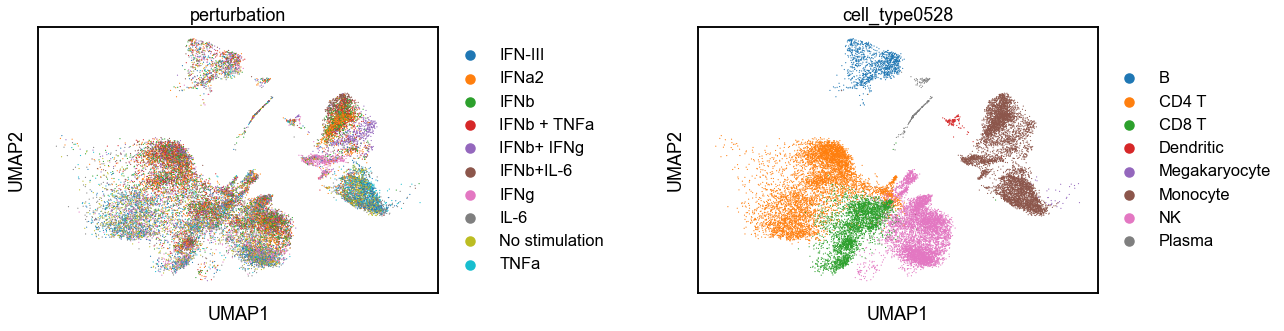

In [3]:
sc.pl.umap(adata_,color=['perturbation','cell_type0528'],wspace=0.5)

# 1. CINEMA-OT analysis of mock->IFNb stimulation effects

First, we perform CINEMA-OT analysis on the subset of mock (no stimulation) to IFNb treatment. CINEMA-OT returns three outputs. First is computed confounder embedding, the second is matching matrix, the third is response matrix. Here we use TT (Treatment effect on Treated) for the matrix. Note the default setting of FastICA has low tolerance for ICA convergence. This harms CINEMA-OT little in practice.

In [4]:
adata_ = adata_[adata_.obs['perturbation'].isin(['No stimulation','IFNb'])]
sc.pp.pca(adata_)
cf, ot, de = co.cinemaot.cinemaot_unweighted(adata_,obs_label='perturbation', ref_label='IFNb', expr_label='No stimulation',mode='parametric',thres=0.5,smoothness=1e-4,eps=1e-2,preweight_label='cell_type0528')

/opt/homebrew/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


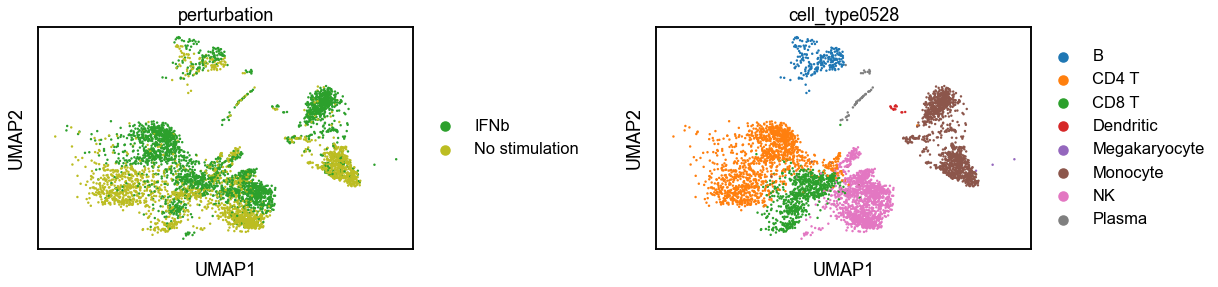

In [5]:
sc.pl.umap(adata_,color=['perturbation','cell_type0528'],wspace=0.5)

Next, we create visualization of response matrix and confounder embedding. 

/var/folders/lh/5h3qxqln0dlfw494qsg03jcc0000gn/T/ipykernel_94822/3447112228.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  mock_IFNb = sc.AnnData(de)
/opt/homebrew/lib/python3.9/site-packages/numba/np/arraymath.py:4044: DeprecationWarning: `np.MachAr` is deprecated (NumPy 1.22).
  @overload(np.MachAr)


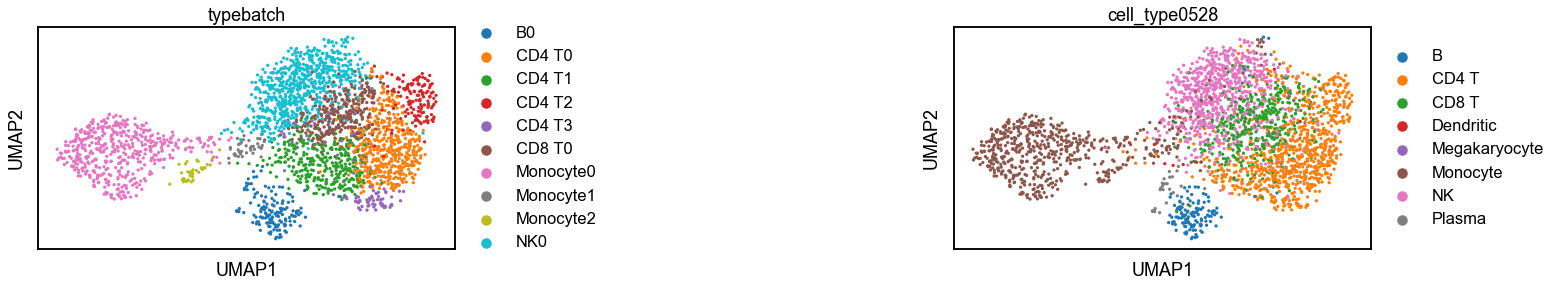

In [6]:
subset_IFNb = adata_[adata_.obs['perturbation'].isin(['IFNb']),:]
mock_IFNb = sc.AnnData(de)
mock_IFNb.obs['cell_type0528'] = subset_IFNb.obs['cell_type0528'].values
mock_IFNb.var_names = subset_IFNb.var_names
sc.pp.pca(mock_IFNb)
sc.pp.neighbors(mock_IFNb)
sc.tl.leiden(mock_IFNb,resolution=1)
sc.tl.umap(mock_IFNb)
co.utils.assignleiden(mock_IFNb,'cell_type0528','leiden','typebatch')
sc.pl.umap(mock_IFNb,color=['typebatch','cell_type0528'],wspace=1)

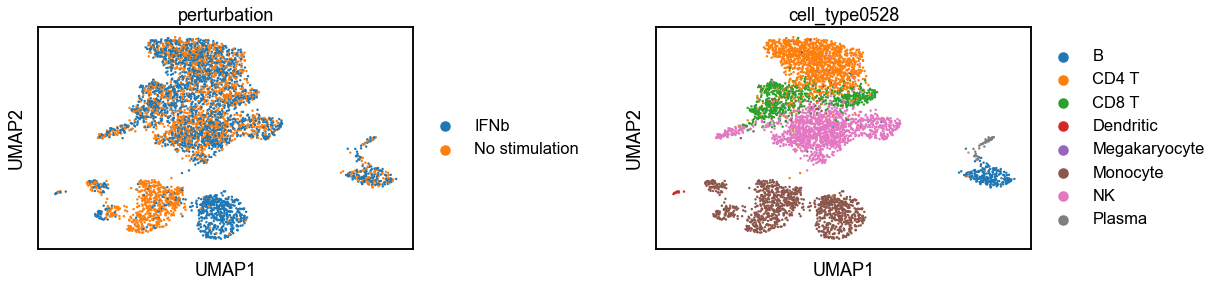

In [7]:
CF = sc.AnnData(cf,obs=adata_.obs)
sc.pp.neighbors(CF)
sc.tl.umap(CF)
sc.pl.umap(CF,color=['perturbation','cell_type0528'],wspace=0.5)

We can see that in confounder embedding, most cell types are perfectly overlapped across treatment conditions, and different cell types are separated. The only exception is Monocyte. As CINEMA-OT uses optimal transport matching, even some of the confounder signals are not perfectly overlapping, they can still be matched based on minimizing transportation cost.

# 2. CINEMA-OT downstream analysis of mock->IFNb

Next, we perform differential expression analysis on the response matrix by logreg method in scanpy.

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


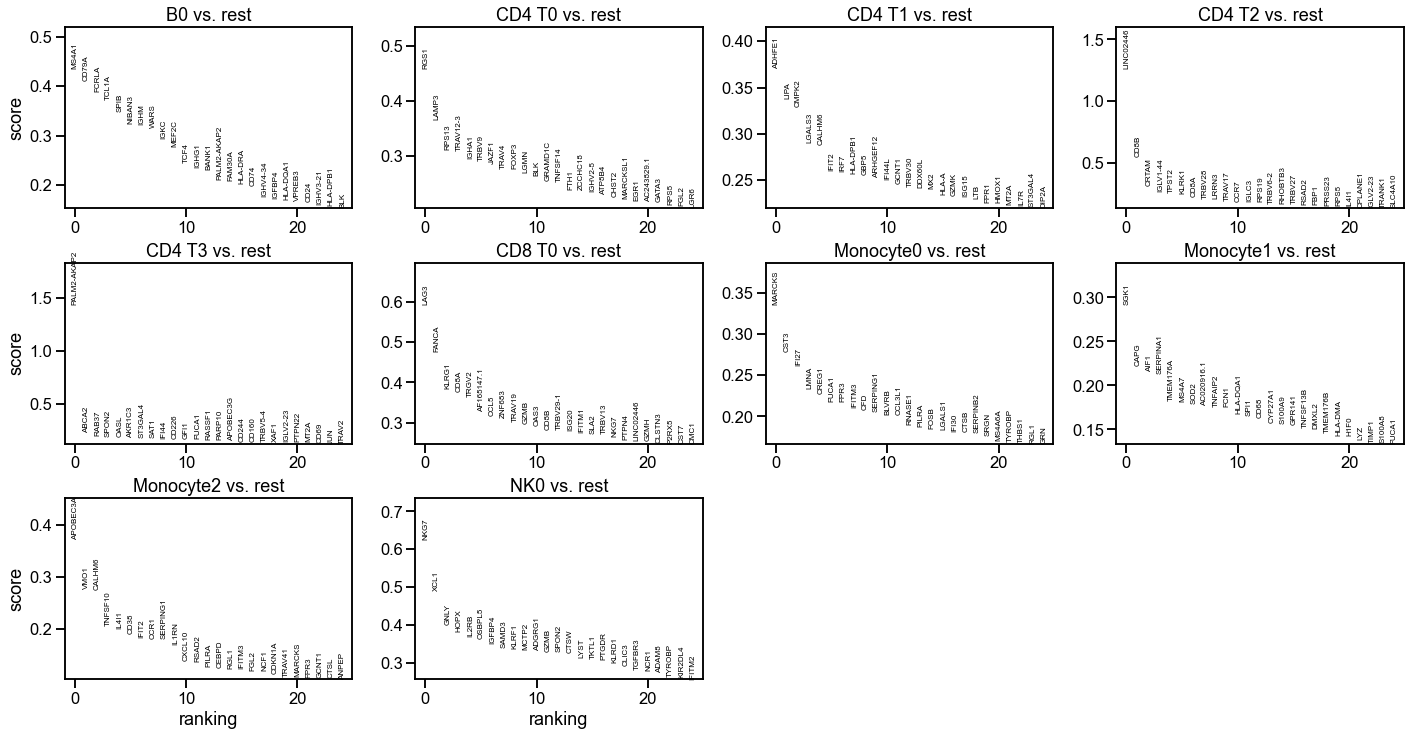

In [8]:
sc.tl.rank_genes_groups(mock_IFNb, 'typebatch', method='logreg')
sc.pl.rank_genes_groups(mock_IFNb, n_genes=25, sharey=False)

We are able to visualize some of the genes that have sub-cluster level differential response in the UMAP embedding of response matrix.

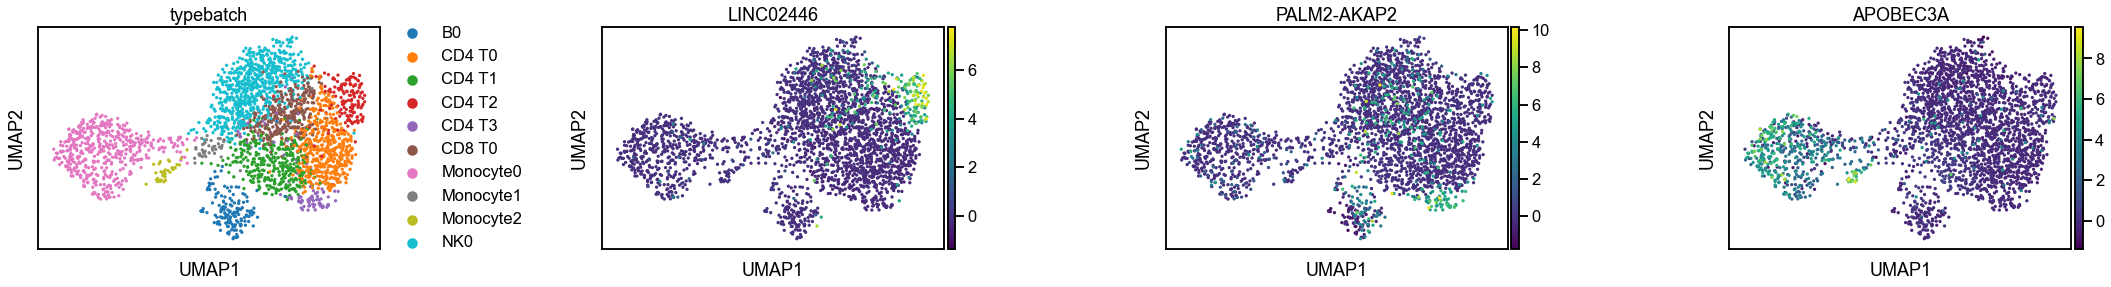

In [9]:
sc.pl.umap(mock_IFNb,color=['typebatch','LINC02446','PALM2-AKAP2','APOBEC3A'],wspace=0.5)

However, apart from differential response, the shared response across clusters can not be revealed this way. CINEMA-OT integrates an non-parametric wilcoxon test in order to identify significant genes. After generating the gene list, GSEApy is used to enrich gene modules significantly regulated for each response sub-cluster. The output are csvs as well as the gene number (genenum), a GSEApy result summary dataframe (df), and the union significantly regulated genes across response clusters(mk).

In [10]:
genenum, df, mk = co.utils.clustertest(mock_IFNb,'leiden',1e-5,np.log(1.5),'typebatch','./genelist4/ifnbH3D2',['./genelist/h.all.v7.5.1.symbols.gmt','./genelist/c5.go.bp.v7.5.1.symbols.gmt'],'human')
genenum

array([ 76., 191.,  81.,  47.,  56.,  72.,  51.,  42.,   7.,  61.])

To attribute differential response, we define coarse-grained matching matrix by arranging rows as differential response clusters and columns as clusters in control condition.

In [11]:
subset_mock = adata_[adata_.obs['perturbation'].isin(['No stimulation']),:].copy()
sc.pp.pca(subset_mock)
sc.pp.neighbors(subset_mock)
sc.tl.umap(subset_mock)
sc.tl.leiden(subset_mock,resolution=1.1)
co.utils.assignleiden(subset_mock,'cell_type0528','leiden','typebatch')
coarse_ot = co.utils.coarse_matching(mock_IFNb,'typebatch',subset_mock,'typebatch',ot)

<AxesSubplot:>

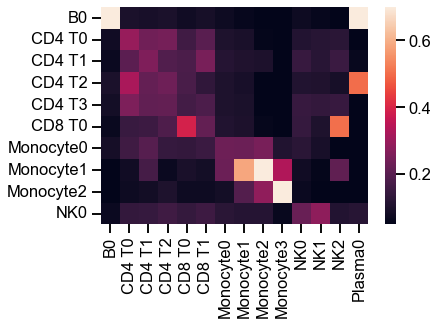

In [12]:
import seaborn as sns
sns.heatmap(coarse_ot,vmax=0.7,vmin=0.05,xticklabels="auto", yticklabels="auto")

We are able to see that monocyte response cluster can be attributed to the difference in control condition monocyte subclusters. Furthermore, in the paper, we have found that an immune suppressor IDO1 expression in control condition, can indicate the low response level in Monocyte response.

# 3. CINEMA-OT synergy analysis

Here we perform synergy effect analysis. In the dataset, we have three combinatorial perturbation cases: IFNb + TNFa; IFNb + IFNg; IFNb + IL-6. Here we perform CINEMA analysis on all cases via a for loop, since three is not too much. Note in the implementation below, the synergy is implemented as the difference between (A+B)+0 and (A)+(B) conditions. This is simplified as a function cinemaot.synergy in the package.

In [19]:
#Filter immune genes (not mandatory)

import pandas as pd
TR = pd.read_csv('TR.txt',sep='\t')
HLA = pd.read_csv('HLA.txt',sep='\t')
IG = pd.read_csv('IG.txt',sep='\t')

filterlist = list(set(TR['Approved symbol'].values.tolist()) | set(HLA['Approved symbol'].values.tolist()) | set(IG['Approved symbol'].values.tolist()))
perturbationlist = list(set(adata.obs['perturbation'].values.tolist()))
adata_ = adata[adata.obs['batch']=='H3D2',:]
adata_ = adata_[:,~adata_.var_names.isin(filterlist)]
response = adata_[adata_.obs['perturbation'].isin(['No stimulation']),:]
for i in perturbationlist:
    if i != 'No stimulation':
        adata_ = adata[adata.obs['batch']=='H3D2',:]
        adata_ = adata_[:,~adata_.var_names.isin(filterlist)]
        adata_ = adata_[adata_.obs['perturbation'].isin(['No stimulation',i]),:]
        sc.pp.pca(adata_)
        cf, ot, de = co.cinemaot.cinemaot_unweighted(adata_,obs_label='perturbation', ref_label='No stimulation', expr_label=i,mode='parametric',thres=0.5,smoothness=1e-4,eps=1e-2,preweight_label='cell_type0528')
        subset_mock = adata_[adata_.obs['perturbation'].isin(['No stimulation']),:]
        de_c = sc.AnnData(subset_mock.X.toarray()-de)
        de_c.obs['cell_type0528'] = subset_mock.obs['cell_type0528'].values
        de_c.obs['perturbation'] = i
        de_c.var_names = subset_mock.var_names
        response = sc.concat([response,de_c])

sc.pp.pca(response)
sc.pp.neighbors(response)
sc.tl.umap(response)
synergylist = ['IFNb','IFNb + TNFa','IFNb+ IFNg','IFNb+IL-6','IFNg','IL-6','No stimulation','TNFa']
combolist = ['IFNb + TNFa','IFNb+ IFNg','IFNb+IL-6']
synergy = response[response.obs['perturbation'].isin(combolist),:].copy()
combo = response[response.obs['perturbation'].isin(combolist),:].copy()
combo.X[combo.obs['perturbation']=='IFNb + TNFa',:] = response.X[response.obs['perturbation']=='IFNb + TNFa',:]-response.X[response.obs['perturbation']=='IFNb',:] - response.X[response.obs['perturbation']=='TNFa',:] + response.X[response.obs['perturbation']=='No stimulation',:]
combo.X[combo.obs['perturbation']=='IFNb+ IFNg',:] = response.X[response.obs['perturbation']=='IFNb+ IFNg',:]-response.X[response.obs['perturbation']=='IFNb',:] - response.X[response.obs['perturbation']=='IFNg',:] + response.X[response.obs['perturbation']=='No stimulation',:]
combo.X[combo.obs['perturbation']=='IFNb+IL-6',:] = response.X[response.obs['perturbation']=='IFNb+IL-6',:]-response.X[response.obs['perturbation']=='IFNb',:] - response.X[response.obs['perturbation']=='IL-6',:] + response.X[response.obs['perturbation']=='No stimulation',:]

combo

/opt/homebrew/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
/var/folders/lh/5h3qxqln0dlfw494qsg03jcc0000gn/T/ipykernel_94822/2217966062.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  de_c = sc.AnnData(subset_mock.X.toarray()-de)
/opt/homebrew/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:120: Conver

AnnData object with n_obs × n_vars = 6804 × 596
    obs: 'perturbation', 'cell_type0528'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Text(0.5, 1.0, 'Gene synergy score distribution')

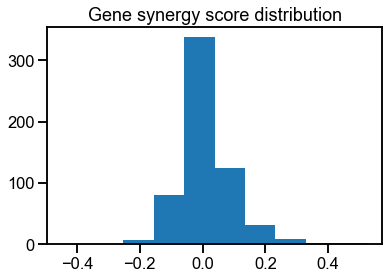

In [14]:
plt.hist(np.mean(combo.X,axis=0))
plt.title('Gene synergy score distribution')

Based on gene synergy, we filter insignificant synergy genes and perform cell synergy analysis.

... storing 'perturbation' as categorical


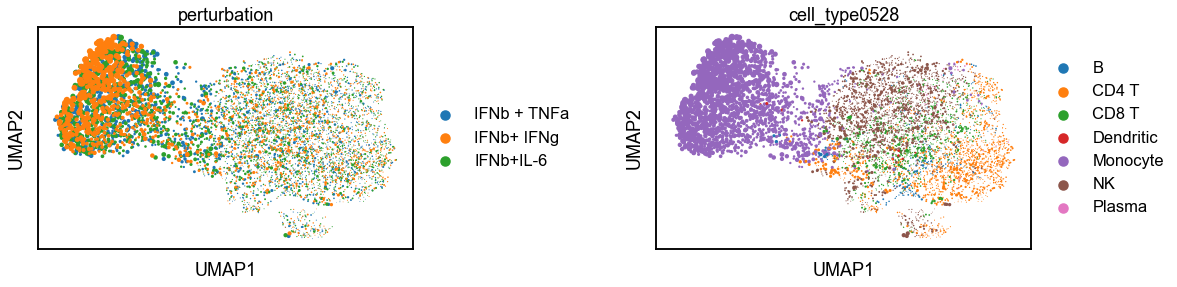

In [20]:
sc.pp.pca(combo)
sc.pp.neighbors(combo)
sc.tl.umap(combo)
synergyscore = np.linalg.norm(combo.X[:,np.abs(np.mean(combo.X,axis=0))>0.15],axis=1)
sc.pl.umap(combo,color=['perturbation','cell_type0528'],wspace=0.5,size=0.3*synergyscore**2)

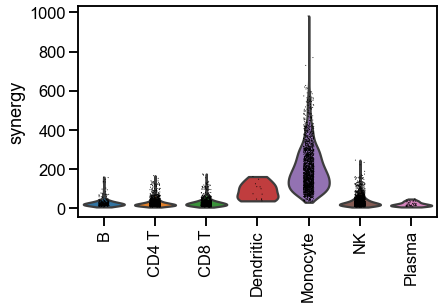

In [17]:
combo.obs['synergy'] = synergyscore ** 2
sc.pl.violin(combo,keys=['synergy'],groupby='cell_type0528',rotation=90)

We can identify different modes of synergistic response through visualization of synergy matrix:

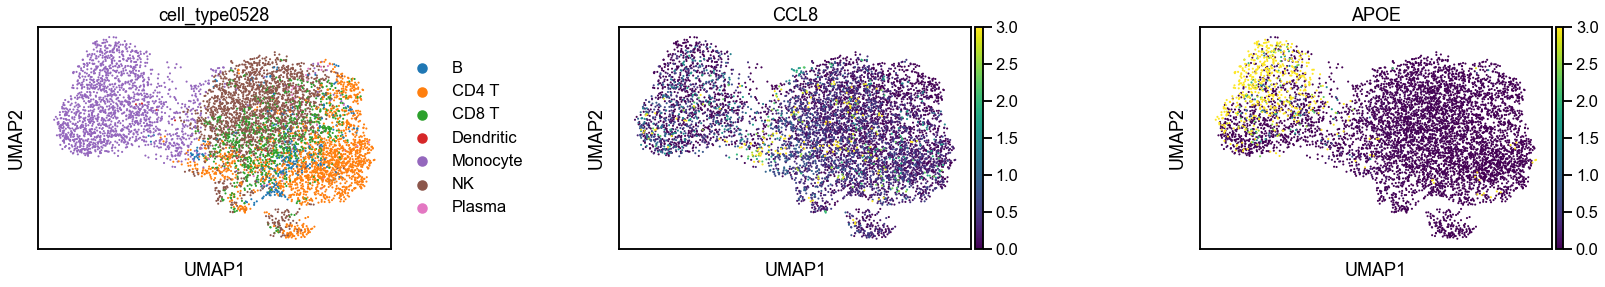

In [24]:
sc.pl.umap(combo,color=['cell_type0528','CCL8','APOE'],wspace=0.5,vmin=0,vmax=3)

Finally, we can plot a stacked violin plot of significant synergy genes selected.

In [26]:
orderlist = np.array([2,3,4,7,10,12,0,1,6,11,8,9,5])
combo.var_names[np.abs(np.mean(combo.X,axis=0))>0.25].values[orderlist]

array(['APOC1', 'APOE', 'CCL3L1', 'CD9', 'GPNMB', 'TREM2', 'ACP5',
       'APOBEC3A', 'CCL8', 'IL1RN', 'CHI3L1', 'CXCL9', 'CCL7'],
      dtype=object)

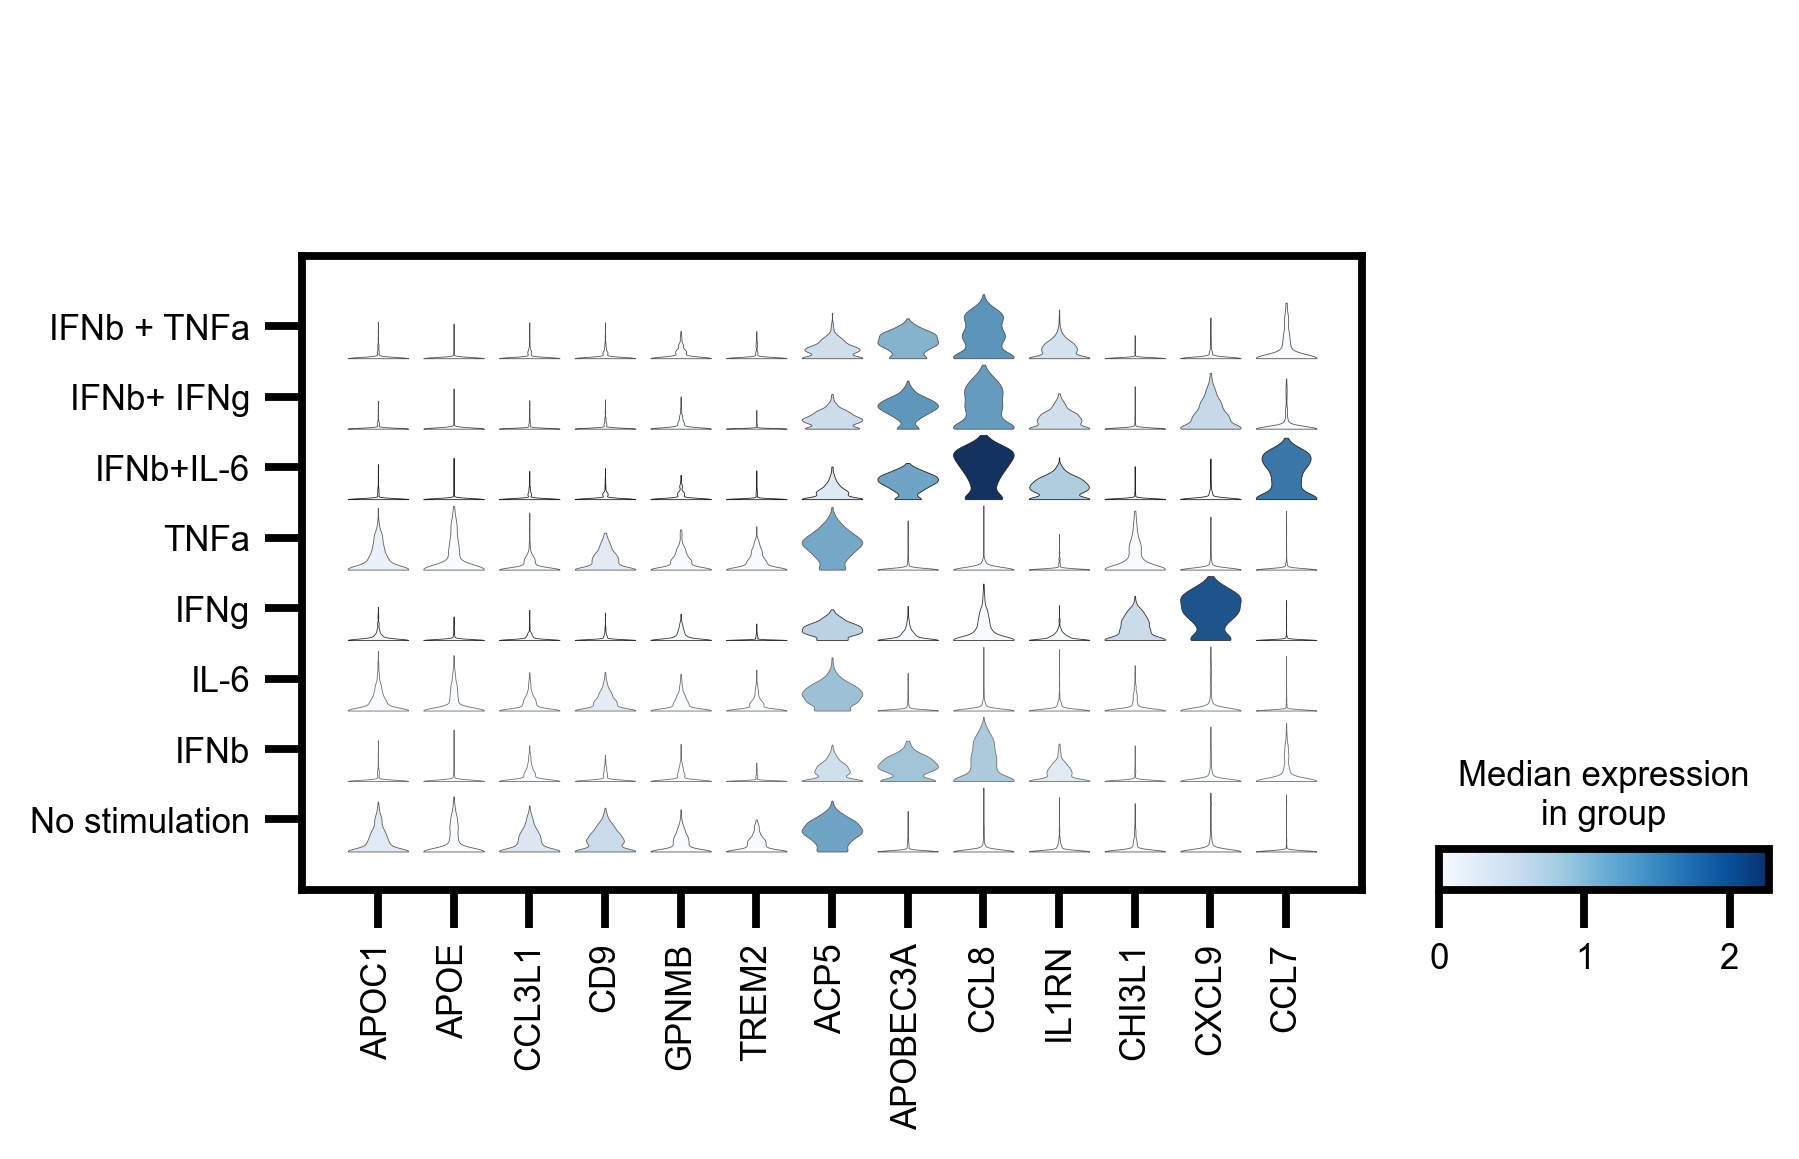

In [37]:
plt.rcParams['figure.dpi'] = 300
adata_ = adata[adata.obs['batch']=='H3D2',:]
adata_ = adata_[adata_.obs['cell_type0528']=='Monocyte',:]
adata_ = adata_[adata_.obs['perturbation'].isin(synergylist),:]
od = ['IFNb + TNFa','IFNb+ IFNg','IFNb+IL-6','TNFa','IFNg','IL-6','IFNb','No stimulation']
sc.pl.stacked_violin(adata_,var_names=combo.var_names[np.abs(np.mean(combo.X,axis=0))>0.25].values[orderlist],groupby='perturbation',categories_order=od,rotation=90)